In [32]:
%pip install dabl
# %pip install dtale
# %pip install imblearn
%pip install keras-tuner
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
import datetime
import shutil
import warnings
from pickle import dump

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, plot
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.datasets import (load_breast_cancer, load_diabetes, load_iris,
                              load_wine)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, chi2, f_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import (RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
plt.rcParams["figure.figsize"] = [12.8, 7.2]
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
!cat /proc/cpuinfo | grep "model name"
!cat /proc/meminfo | grep "MemTotal"
!nvidia-smi

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15219467339757263390
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16152002560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6006865970598757167
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


2022-04-10 04:59:29.001431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 04:59:29.002120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 04:59:29.002609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 04:59:29.003197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 04:59:29.003667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal:       16394012 kB
Sun Apr 10 04:59:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |  15849MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

In [34]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 0
CLASSIFICATION = 0

In [35]:
df, y_label = pd.read_csv("https://raw.githubusercontent.com/lyoh001/AzureML/main/data.csv", delimiter=","), "Reco_Policy_Premium"

print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))

Current Shape: (21805, 13).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (21805, 13).


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
2867,53750,C16,2271,Owned,Individual,38,38,No,X6,9.0,1.0,19,8288.0
7662,58545,C1,1002,Owned,Individual,58,58,No,NaN,3.0,3.0,19,13520.0
12327,63210,C2,2751,Owned,Joint,72,70,Yes,X4,5.0,4.0,20,27865.6


In [36]:
df.drop(["ID", "Holding_Policy_Duration", "Holding_Policy_Type", "Region_Code"], inplace=True, axis=1)
df.dropna(subset=[y_label], inplace=True)
print("Data cleaning has been completed.")

Data cleaning has been completed.


In [37]:
print(f"Current Shape: {df.shape}.")
df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if np.issubsctype(df[col].dtype, np.number) else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)

Current Shape: (21805, 9).


,column,dtype,na,na %,outliers,outliers %,skewness,corr,nunique,unique
0,City_Code,object,0,0%,n/a,n/a,n/a,n/a,36,"[C1, C4, C3, C2, C13, C18, C16, C17, C11, C7, ..."
1,Accomodation_Type,object,0,0%,n/a,n/a,n/a,n/a,2,"[Owned, Rented]"
2,Reco_Insurance_Type,object,0,0%,n/a,n/a,n/a,n/a,2,"[Individual, Joint]"
5,Is_Spouse,object,0,0%,n/a,n/a,n/a,n/a,2,"[No, Yes]"
6,Health Indicator,object,5027,23%,n/a,n/a,n/a,n/a,9,"[nan, X1, X3, X2, X5, X4, X7, X6, X9, X8]"
3,Upper_Age,int64,0,0%,0,0%,0.21,79%,58,"[30, 69, 28, 23, 75, 24, 56, 41, 22, 38, 42, 3..."
4,Lower_Age,int64,0,0%,0,0%,0.33,61%,60,"[30, 68, 28, 23, 75, 24, 56, 41, 22, 37, 38, 4..."
7,Reco_Policy_Cat,int64,0,0%,0,0%,-0.93,6%,22,"[5, 18, 17, 16, 22, 21, 19, 20, 11, 9, 14, 13,..."
8,Reco_Policy_Premium,float64,0,0%,291,1%,0.74,100%,5226,"[11934.0, 32204.8, 9240.0, 9086.0, 22534.0, 61..."


In [38]:
OUTLIERS = ["keep", "cap", "log_transform", "drop"][0]
col_outlier = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col in [""]]
q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
iqr = q3 - q1
lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Scanning for outliers in {col_outlier}.")
print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
if OUTLIERS == "keep":
    print(f"Outliers have been kept {df.shape}.")
elif OUTLIERS == "cap":
    for col in col_outlier:
        df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
        df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
    print(f"Outliers have been capped {df.shape}.")
elif OUTLIERS == "log_transform":
    for col in col_outlier:
        df[col] = np.log(df[col])
    print(f"Outliers have been log transformed {df.shape}.")
else:
    df = df[condition]
    print(f"Outliers have been removed {df.shape}.")

Current Shape: (21805, 9).
-------------------------------------------------------
Scanning for outliers in [].
Outliers Percentage: 0.00%
Outliers have been kept (21805, 9).


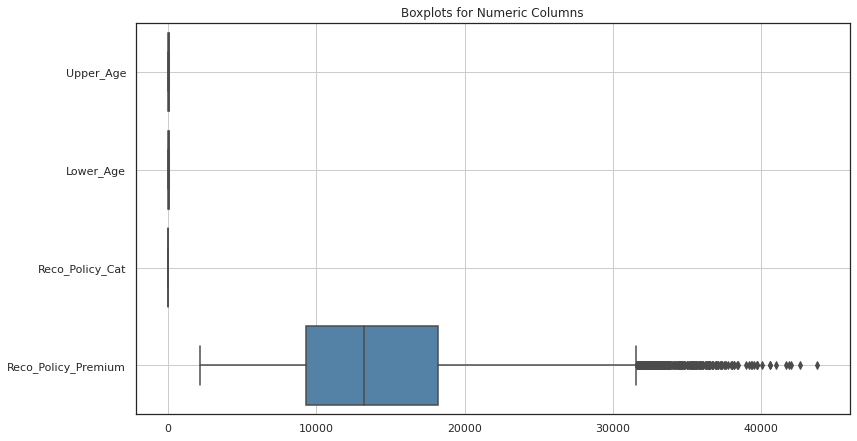

In [39]:
plt.title("Boxplots for Numeric Columns")
sns.boxplot(
    data=df[[col for col in df.columns if np.issubsctype(df[col].dtype, np.number)]],
    orient="h",
    color="steelblue"
)
plt.grid()
plt.show()

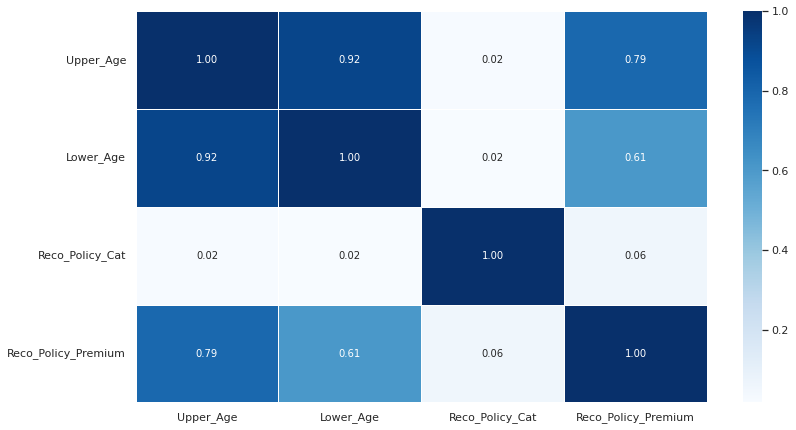

In [40]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.show()

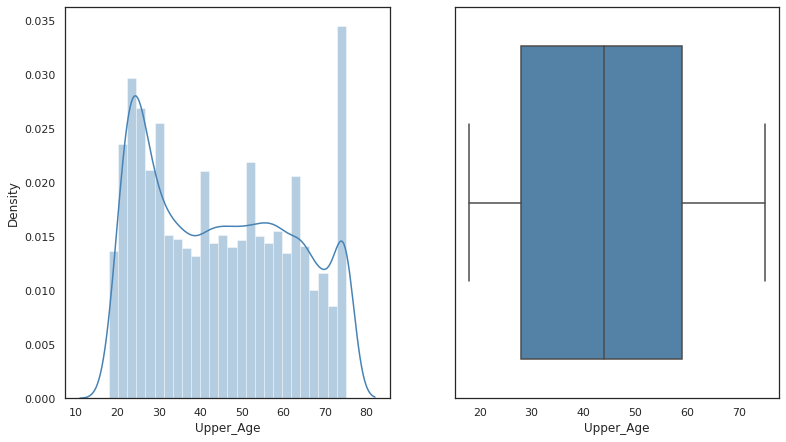

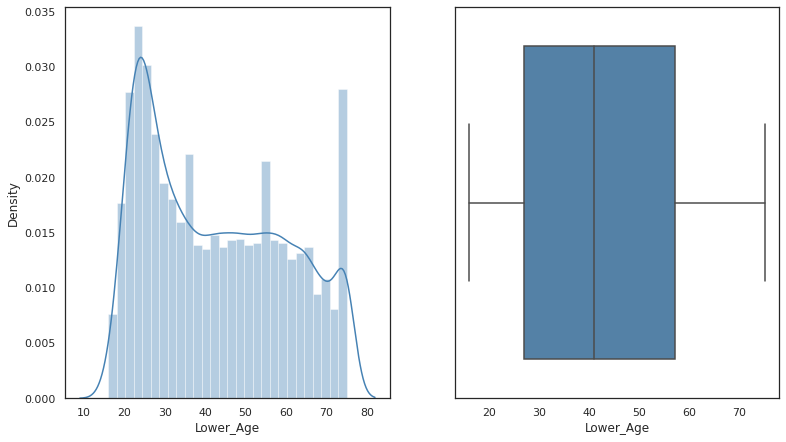

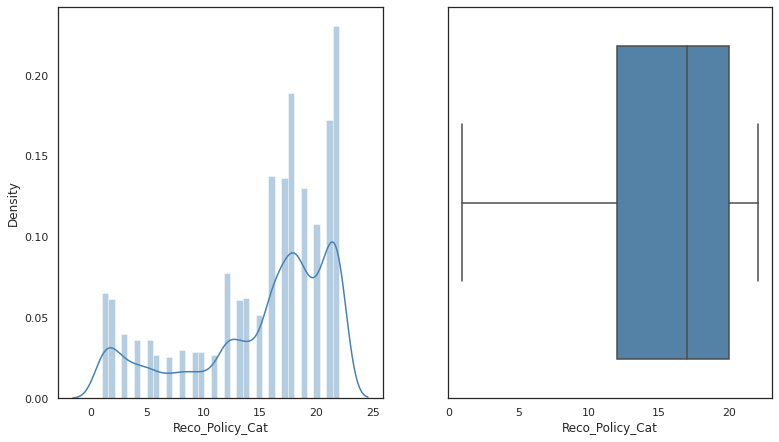

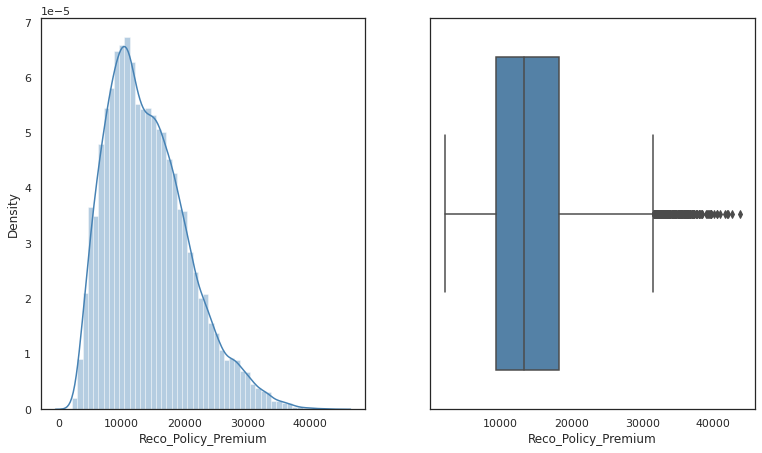

In [41]:
for col in df.columns:
    if np.issubsctype(df[col].dtype, np.number):
        fig, ax = plt.subplots(nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.distplot(x=df[col], ax=ax[0], color="steelblue", kde=True).set_xlabel(f"{col}")
        sns.boxplot(x=df[col], ax=ax[1], color="steelblue").set_xlabel(f"{col}")
plt.show()

In [42]:
if CLASSIFICATION:
    for col in df.columns:
        if np.issubsctype(df[col].dtype, np.number):
            fig, ax = plt.subplots(nrows=1, ncols=1)
            sns.set(style="white", palette="muted", color_codes=True)
            sns.boxplot(x=y_label, y=col, data=df, color="steelblue")
    plt.show()

In [43]:
display(df.describe().round(2).T.style.background_gradient(cmap="Blues"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues"))

,count,mean,std,min,25%,50%,75%,max
Upper_Age,21805.000000,44.880000,17.250000,18.000000,28.000000,44.000000,59.000000,75.000000
Lower_Age,21805.000000,42.750000,17.270000,16.000000,27.000000,41.000000,57.000000,75.000000
Reco_Policy_Cat,21805.000000,15.140000,6.300000,1.000000,12.000000,17.000000,20.000000,22.000000
Reco_Policy_Premium,21805.000000,14220.310000,6498.000000,2152.000000,9285.000000,13244.000000,18201.600000,43776.000000


,0.01,0.99
Upper_Age,19.000000,75.000000
Lower_Age,18.000000,75.000000
Reco_Policy_Cat,1.000000,22.000000
Reco_Policy_Premium,3846.000000,32536.688000


In [44]:
OVERSAMPLE = ["none", "undersample", "oversample", "combine"][0]
X, y = df.drop(y_label, axis=1), df[y_label]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
col_oe = ["Health Indicator"]
preprocessor_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9"]])),
    (MinMaxScaler()),
)
col_ohe = [
    col
    for col in X_train.columns
    if np.issubsctype(X_train[col].dtype, np.object0)
    and col not in col_oe
    and X_train[col].nunique() <= 50
]
preprocessor_ohe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OneHotEncoder(drop="first", handle_unknown="ignore")),
)
col_num = [
    col for col in X_train.columns if np.issubsctype(X_train[col].dtype, np.number)
]
preprocessor_num = make_pipeline(
    (KNNImputer()),
    (MinMaxScaler()),
)
preprocessor = make_column_transformer(
    (preprocessor_oe, col_oe),
    (preprocessor_ohe, col_ohe),
    (preprocessor_num, col_num),
    sparse_threshold=0
)
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_oe: {col_oe}")
print(f"col_ohe: {col_ohe}")
print(f"col_num: {col_num}")
print(f"total cols for preprocessor: {len(col_oe) + len(col_ohe) + len(col_num)}")
if CLASSIFICATION:
    if OVERSAMPLE == "undersample":
        X_train_processed, y_train_processed = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy="not minority").fit_resample(X_train_processed, y_train_processed)
    elif OVERSAMPLE == "oversample":
        X_train_processed, y_train_processed = SMOTE(random_state=RANDOM_STATE, sampling_strategy="not majority").fit_resample(X_train_processed, y_train_processed)
    elif OVERSAMPLE == "combine":
        X_train_processed, y_train_processed = SMOTEENN(random_state=RANDOM_STATE, sampling_strategy="not majority").fit_resample(X_train_processed, y_train_processed)
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0], palette="Blues").set_xlabel("y")
    sns.countplot(y_train, ax=ax[1], palette="Blues").set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2], palette="Blues").set_xlabel("y_train_processed")
    plt.show()
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

-------------------------------------------------------
total na %: 2.56%
-------------------------------------------------------
col_oe: ['Health Indicator']
col_ohe: ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse']
col_num: ['Upper_Age', 'Lower_Age', 'Reco_Policy_Cat']
total cols for preprocessor: 8
-------------------------------------------------------
X: (21805, 8)	X_train: (17444, 8)	X_train_processed:(17444, 42)	X_test: (4361, 8)		X_test_processed:(4361, 42)
y: (21805,)	y_train: (17444,)		y_train_processed:(17444,)	y_test: (4361,)		y_test_processed:(4361,)
-------------------------------------------------------


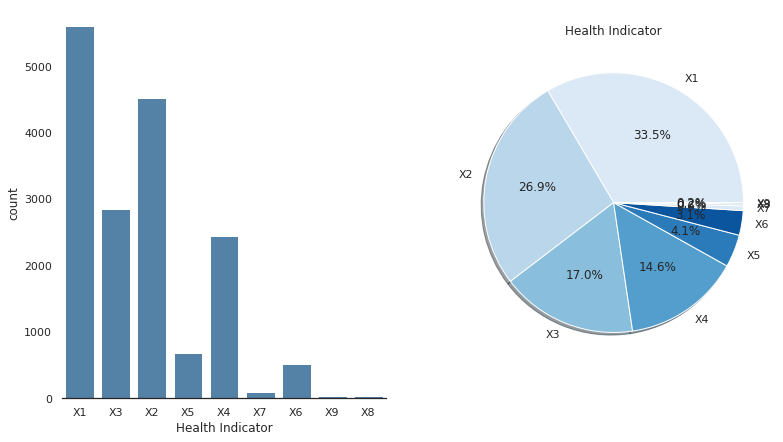

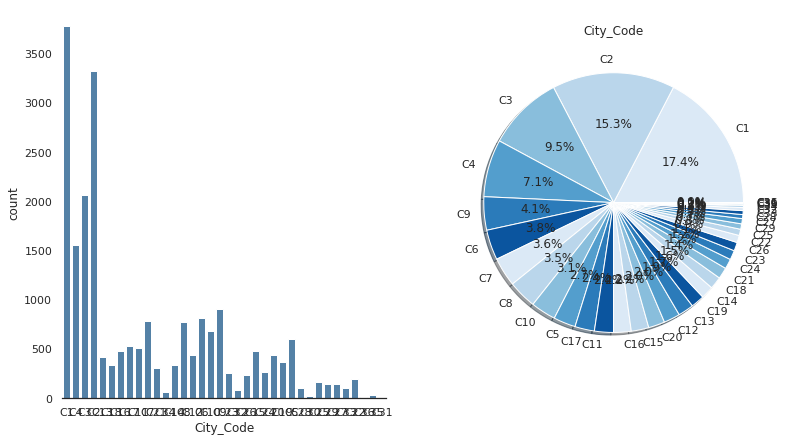

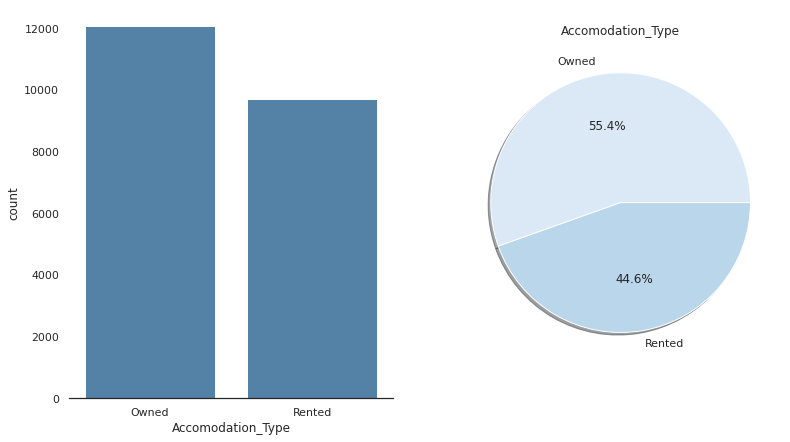

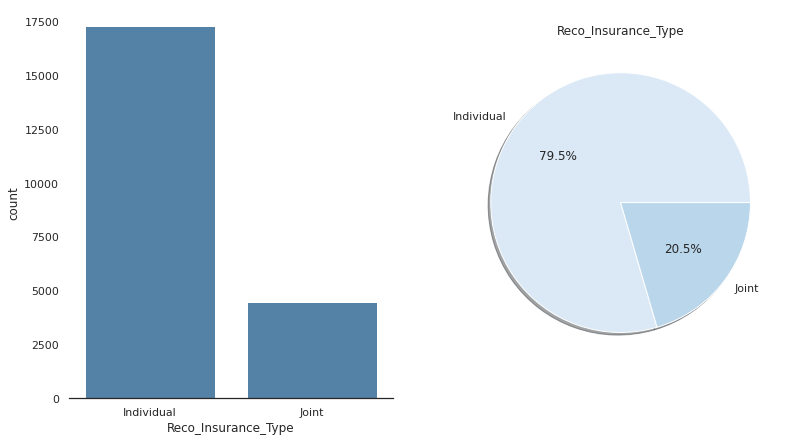

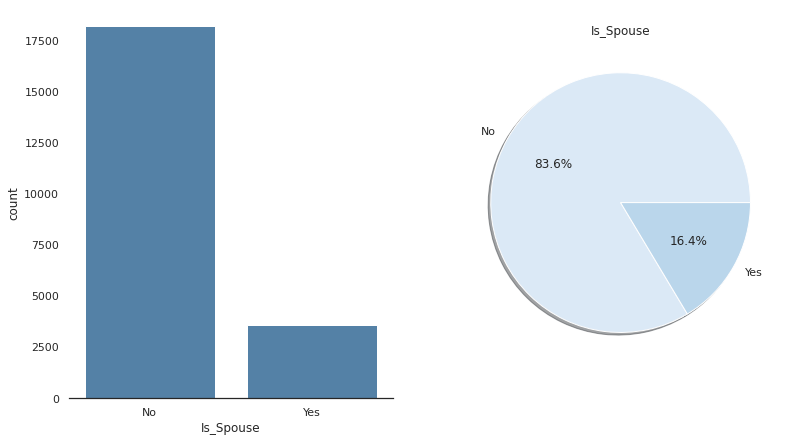

In [45]:
for col in col_oe + col_ohe:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.set(style="white", palette="muted", color_codes=True)
    sns.despine(left=True)
    sns.countplot(x=df[col], ax=ax[0], color="steelblue", hue=df[y_label] if CLASSIFICATION else None).set_xlabel(f"{col}")
    ax[1].pie(x=df[col].value_counts(), colors=sns.color_palette("Blues"), autopct="%.1f%%", shadow=True, labels=df[col].value_counts().index)
    ax[1].set_title(col)
plt.show()

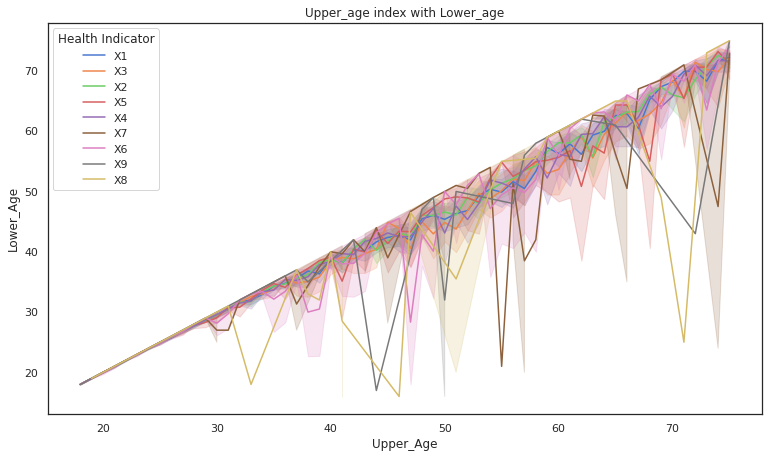

In [46]:
if len(col_oe + col_ohe) >= 1 and len(col_num) >= 2:
    sns.lineplot(data=df, x=col_num[0], y=col_num[1], hue=(col_oe + col_ohe)[0])
    plt.title(f"{col_num[0].capitalize()} index with {col_num[1].capitalize()}")
    plt.show()

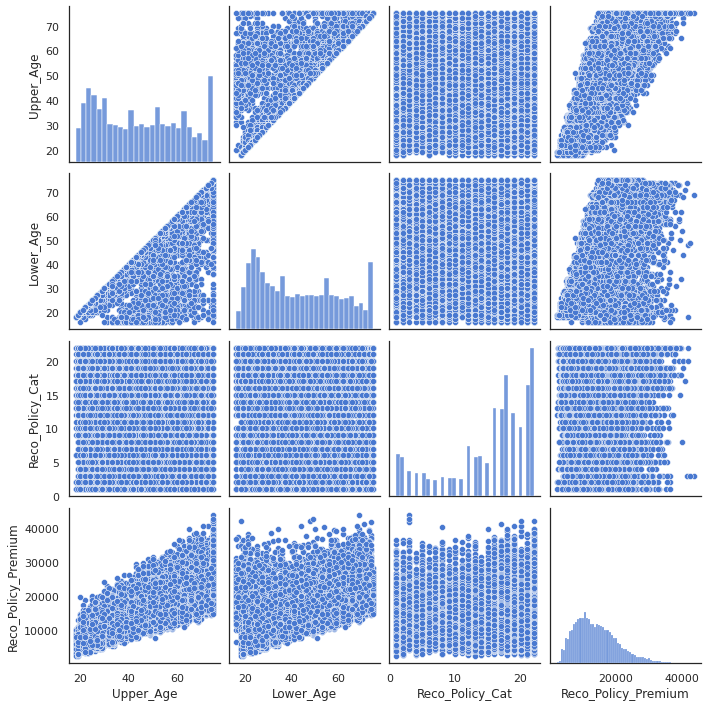

In [47]:
sns.pairplot(df, hue=y_label if CLASSIFICATION else None)

Target looks like regression


[array([[<AxesSubplot:title={'center':'F=3.59E+04'}, xlabel='Upper_Age', ylabel='Reco_Policy_Premium'>,
         <AxesSubplot:title={'center':'F=1.28E+04'}, xlabel='Lower_Age'>,
         <AxesSubplot:title={'center':'F=7.65E+01'}, xlabel='Reco_Policy_Cat'>]],
       dtype=object),
 None]

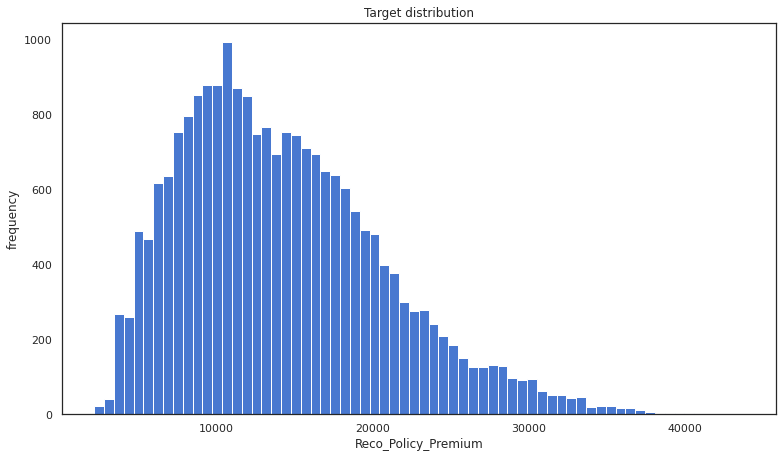

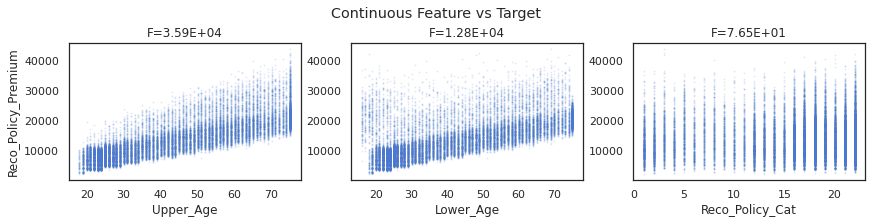

In [48]:
# import dtale
# dtale.show(df)
plot(X[col_num], y)

In [49]:
def build_ml_model():
    tests = [
        {
            "model": make_pipeline(
                (preprocessor),
                (SelectPercentile()),
                (RandomForestClassifier()) if CLASSIFICATION else (LinearRegression()),
            ),
            "params": {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "randomforestclassifier__n_estimators": [100, 150, 200, 500],
                "randomforestclassifier__criterion": ["gini", "entropy"],
                "randomforestclassifier__max_depth": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_split": [2, 5, 10, 20, 50, 100, 200],
                "randomforestclassifier__min_samples_leaf": [5, 10, 20, 50, 100, 200],
                "randomforestclassifier__max_features": ["auto", "sqrt", "log2"],
            }
            if CLASSIFICATION
            else {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
            },
        },
    ]
    for test in tests:
        rscv = RandomizedSearchCV(
            estimator=test["model"],
            param_distributions=test["params"],
            n_jobs=-1,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
            if CLASSIFICATION
            else 10,
            scoring="accuracy" if CLASSIFICATION else "r2",
            n_iter=10,
            return_train_score=True,
        )
        rscv.fit(X_train, y_train)
        print("===train============================")
        print(f"{rscv.best_score_ * 100:.2f}%\n{test['model'][-1]}\n{rscv.best_params_}")
        print("===params============================")
        display(pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_score"))
        print("===test============================")
        print(f"test score:{rscv.score(X_test, y_test) * 100:.2f}%")
        print("====end===========================\n")

    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test,
                rscv.predict(X_test),
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test,
                rscv.predict(X_test),
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            f"r2: {r2_score(y_test, rscv.predict(X_test)):.3f} neg_mean_squared_error: -{mean_squared_error(y_test, rscv.predict(X_test)):_.3f}"
        )

        plt.subplot(1, 3, 1)
        sns.regplot(y_train, y_train, color="darkorange", label="Truth")
        sns.regplot(
            y_test,
            rscv.predict(X_test),
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.scatter(
            rscv.predict(X_train),
            rscv.predict(X_train) - y_train,
            c="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        plt.scatter(
            rscv.predict(X_test),
            rscv.predict(X_test) - y_test,
            c="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc="upper right")
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train - rscv.predict(X_train)))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()
    display(
        pd.DataFrame(
            {
                "Truth": y_test[:10].values,
                "Predicted": rscv.predict(X_test[:10]).round(1),
            }
        )
    )

def build_dl_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("input_00", min_value=32, max_value=512, step=32),
            input_shape=X_train_processed.shape[1:],
        )
    )
    for i in range(1, hp.Int("num_layers", min_value=2, max_value=64)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"hidden_{i:02}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(
        keras.layers.Dense(
            units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
            activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
        )
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss=["mean_squared_error", "binary_crossentropy", "sparse_categorical_crossentropy"][CLASSIFICATION],
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model

def get_result(epochs):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=epochs,
        validation_split=0.2,
        verbose=1,
    )
    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(df, target_col=y_label)
        print("-------------------------------------------------------")
        print(f"r2: {r2_score(y_test_processed, model.predict(X_test_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_test_processed, model.predict(X_test_processed)):_.3f}")
    
        plt.subplot(1, 3, 1)
        sns.regplot(y_train_processed, y_train_processed, color="darkorange", label="Truth")
        sns.regplot(
            y_test_processed,
            model.predict(X_test_processed).T[0],
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.scatter(
            model.predict(X_train_processed).T[0],
            model.predict(X_train_processed).T[0] - y_train_processed,
            c="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        plt.scatter(
            model.predict(X_test_processed).T[0],
            model.predict(X_test_processed).T[0] - y_test_processed,
            c="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.xlabel("Predicted values")
        plt.ylabel("Residuals")
        plt.legend(loc="upper right")
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train_processed - model.predict(X_train_processed).T[0]))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test_processed[:10].values,
                "Predicted": [
                    model.predict(X_test_processed[:10]).T[0],
                    model.predict(X_test_processed[:10]).T[0].round(),
                    np.argmax(model.predict(X_test_processed[:10]), axis=1),
                ][CLASSIFICATION],
            }
        )
    )
    return model

if SEARCH == "hyperband":
    tuner = Hyperband(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        build_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_00 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 64, 'step': 1, 'sampling': None}
hidden_01 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [50]:
%%time
tuner.search(
    X_train_processed,
    y_train_processed,
    batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
    callbacks=[early_stop],
    epochs=MAX_TRIALS,
    validation_split=0.2,
    verbose=1,
)
tuner.results_summary()

Trial 30 Complete [00h 00m 04s]
val_mean_squared_error: 35694048.0

Best val_mean_squared_error So Far: 7384319.5
Total elapsed time: 00h 02m 49s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
input_00: 96
num_layers: 60
hidden_01: 160
dropout: 0.0
learning_rate: 0.001
hidden_02: 352
hidden_03: 480
hidden_04: 256
hidden_05: 224
hidden_06: 224
hidden_07: 480
hidden_08: 512
hidden_09: 256
hidden_10: 480
hidden_11: 288
hidden_12: 128
hidden_13: 288
hidden_14: 256
hidden_15: 384
hidden_16: 64
hidden_17: 384
hidden_18: 384
hidden_19: 448
hidden_20: 320
hidden_21: 128
hidden_22: 448
hidden_23: 224
hidden_24: 160
hidden_25: 128
hidden_26: 480
hidden_27: 192
hidden_28: 256
hidden_29: 192
hidden_30: 96
hidden_31: 480
hidden_32: 32
hidden_33: 384
hidden_34: 448
hidden_35: 480
hidden_36: 448
hidden_37: 512
hidden_38: 320
hidden_39: 448
hidden_40: 192
hidden_41: 64
hidden_42: 320
hidden_43: 16

Epoch 1/500
55/55 [==============================] - 3s 17ms/step - loss: 2850110208.0000 - mean_squared_error: 2850110208.0000 - val_loss: 46159920.0000 - val_mean_squared_error: 46159920.0000
Epoch 2/500
55/55 [==============================] - 0s 9ms/step - loss: 206634752.0000 - mean_squared_error: 206634752.0000 - val_loss: 102287536.0000 - val_mean_squared_error: 102287536.0000
Epoch 3/500
55/55 [==============================] - 0s 9ms/step - loss: 24950784.0000 - mean_squared_error: 24950784.0000 - val_loss: 10410719.0000 - val_mean_squared_error: 10410719.0000
Epoch 4/500
55/55 [==============================] - 0s 9ms/step - loss: 9551938.0000 - mean_squared_error: 9551938.0000 - val_loss: 8133302.5000 - val_mean_squared_error: 8133302.5000
Epoch 5/500
55/55 [==============================] - 0s 9ms/step - loss: 8369982.5000 - mean_squared_error: 8369982.5000 - val_loss: 7837262.0000 - val_mean_squared_error: 7837262.0000
Epoch 6/500
55/55 [==============================] - 0

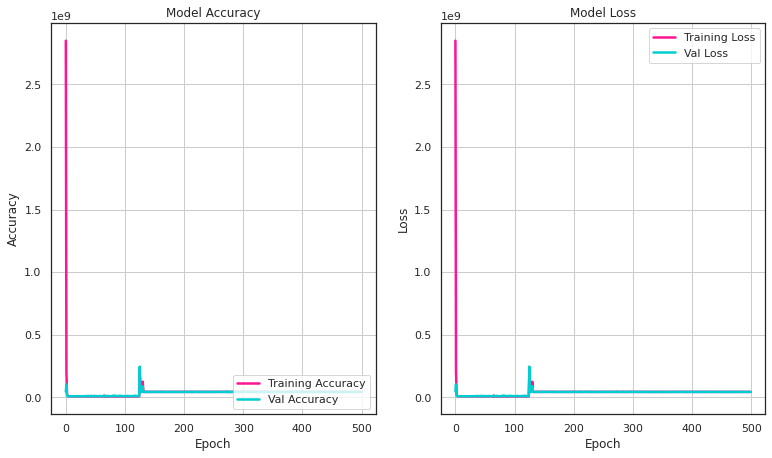

CPU times: user 4min 30s, sys: 11.9 s, total: 4min 42s
Wall time: 4min 25s


In [51]:
%%time
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train_processed,
    y_train_processed,
    batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1,
)
val_per_epoch = history.history[
    ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
]
best_epoch = val_per_epoch.index([min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]) + 1

plt.subplot(1, 2, 1)
plt.plot(history.history[["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]], color='deeppink', linewidth=2.5)
plt.plot(history.history[["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]], color='darkturquoise', linewidth=2.5)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], color='deeppink', linewidth=2.5)
plt.plot(history.history["val_loss"], color='darkturquoise', linewidth=2.5)
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Val Loss"], loc="upper right")
plt.grid()
plt.show()

Best epoch: 12
Epoch 1/12
55/55 [==============================] - 3s 17ms/step - loss: 312514432.0000 - mean_squared_error: 312514432.0000 - val_loss: 69185192.0000 - val_mean_squared_error: 69185192.0000
Epoch 2/12
55/55 [==============================] - 1s 9ms/step - loss: 155466144.0000 - mean_squared_error: 155466144.0000 - val_loss: 19180924.0000 - val_mean_squared_error: 19180924.0000
Epoch 3/12
55/55 [==============================] - 0s 9ms/step - loss: 11701274.0000 - mean_squared_error: 11701274.0000 - val_loss: 8193817.5000 - val_mean_squared_error: 8193817.5000
Epoch 4/12
55/55 [==============================] - 0s 9ms/step - loss: 8160352.5000 - mean_squared_error: 8160352.5000 - val_loss: 7917895.0000 - val_mean_squared_error: 7917895.0000
Epoch 5/12
55/55 [==============================] - 0s 9ms/step - loss: 7867801.5000 - mean_squared_error: 7867801.5000 - val_loss: 8183948.5000 - val_mean_squared_error: 8183948.5000
Epoch 6/12
55/55 [==============================] 

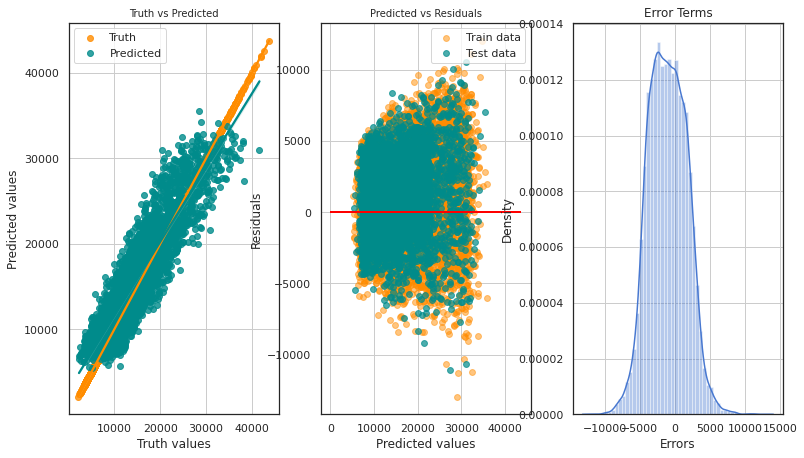

,Truth,Predicted
0,8992.0,10975.600586
1,25113.6,29390.203125
2,24315.2,26944.884766
3,14976.0,12898.113281
4,8992.0,11585.354492
5,18840.0,24582.580078
6,25410.0,28491.763672
7,12915.0,12800.390625
8,11502.0,12222.062500
9,20010.0,21847.517578


CPU times: user 23.3 s, sys: 2.48 s, total: 25.8 s
Wall time: 22.4 s


In [57]:
%%time
print(f"Best epoch: {best_epoch}")
model = get_result(best_epoch)

Epoch 1/30
55/55 [==============================] - 4s 17ms/step - loss: 282259872.0000 - mean_squared_error: 282259872.0000 - val_loss: 241143568.0000 - val_mean_squared_error: 241143568.0000
Epoch 2/30
55/55 [==============================] - 0s 9ms/step - loss: 237453056.0000 - mean_squared_error: 237453056.0000 - val_loss: 245050736.0000 - val_mean_squared_error: 245050736.0000
Epoch 3/30
55/55 [==============================] - 0s 9ms/step - loss: 242253952.0000 - mean_squared_error: 242253952.0000 - val_loss: 245038736.0000 - val_mean_squared_error: 245038736.0000
Epoch 4/30
55/55 [==============================] - 1s 9ms/step - loss: 146877168.0000 - mean_squared_error: 146877168.0000 - val_loss: 45966020.0000 - val_mean_squared_error: 45966020.0000
Epoch 5/30
55/55 [==============================] - 0s 9ms/step - loss: 21131596.0000 - mean_squared_error: 21131596.0000 - val_loss: 7941479.5000 - val_mean_squared_error: 7941479.5000
Epoch 6/30
55/55 [=============================

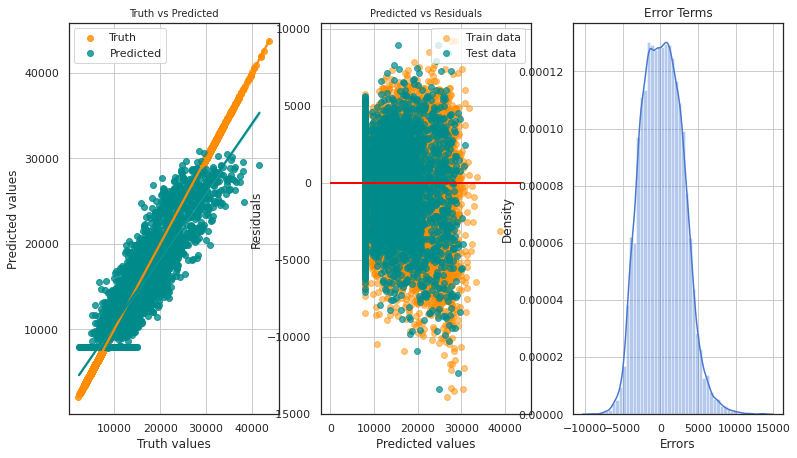

,Truth,Predicted
0,8992.0,10912.149414
1,25113.6,26365.642578
2,24315.2,24306.105469
3,14976.0,12706.649414
4,8992.0,10754.077148
5,18840.0,23773.146484
6,25410.0,26074.613281
7,12915.0,11419.956055
8,11502.0,12357.907227
9,20010.0,19298.736328


In [58]:
model = get_result(30)

===train============================
81.56%
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                 normalize='deprecated', positive=False)
{'selectpercentile__score_func': <function f_classif at 0x7f1746cfee60>, 'selectpercentile__percentile': 80, 'columntransformer__pipeline-3__knnimputer__n_neighbors': 7}
===params============================


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectpercentile__score_func,param_selectpercentile__percentile,param_columntransformer__pipeline-3__knnimputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
8,0.979421,0.111300,0.018078,0.001797,<function f_classif at 0x7f1746cfee60>,80,7,{'selectpercentile__score_func': <function f_c...,0.807303,0.814572,0.818997,0.812256,0.814379,0.812282,0.816784,0.821411,0.81304,0.824829,0.815585,0.004817,1,0.817308,0.816761,0.816056,0.817053,0.816450,0.817026,0.816458,0.816044,0.816988,0.815469,0.816561,0.000546
9,0.977868,0.073281,0.020697,0.009603,<function f_classif at 0x7f1746cfee60>,60,5,{'selectpercentile__score_func': <function f_c...,0.806663,0.813940,0.818872,0.811940,0.814379,0.812473,0.816891,0.820838,0.81242,0.824385,0.815280,0.004831,2,0.817075,0.816196,0.815676,0.816495,0.816144,0.816304,0.815855,0.815643,0.816494,0.814994,0.816088,0.000546
0,0.098167,0.010098,0.000000,0.000000,<function chi2 at 0x7f1746d043b0>,50,1,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.135042,0.039012,0.000000,0.000000,<function chi2 at 0x7f1746d043b0>,10,1,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.121245,0.031278,0.000000,0.000000,<function chi2 at 0x7f1746d043b0>,30,3,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.101926,0.008509,0.000000,0.000000,<function chi2 at 0x7f1746d043b0>,40,5,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.101097,0.005799,0.000000,0.000000,<function chi2 at 0x7f1746d043b0>,90,3,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.140731,0.052277,0.000000,0.000000,<function chi2 at 0x7f1746d043b0>,30,1,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.181064,0.054855,0.000000,0.000000,<function chi2 at 0x7f1746d043b0>,70,5,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.106573,0.009673,0.000000,0.000000,<function chi2 at 0x7f1746d043b0>,90,5,{'selectpercentile__score_func': <function chi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===test============================
test score:81.42%
====end===========================

Running DummyRegressor()
r2: -0.000 neg_mean_squared_error: -42223285.753
=== new best DummyRegressor() (using r2):
r2: -0.000 neg_mean_squared_error: -42223285.753

Running DecisionTreeRegressor(max_depth=1)
r2: 0.479 neg_mean_squared_error: -21984687.092
=== new best DecisionTreeRegressor(max_depth=1) (using r2):
r2: 0.479 neg_mean_squared_error: -21984687.092

Running DecisionTreeRegressor(max_depth=5)
r2: 0.822 neg_mean_squared_error: -7524783.467
=== new best DecisionTreeRegressor(max_depth=5) (using r2):
r2: 0.822 neg_mean_squared_error: -7524783.467

Running Ridge(alpha=10)
r2: 0.825 neg_mean_squared_error: -7381776.786
=== new best Ridge(alpha=10) (using r2):
r2: 0.825 neg_mean_squared_error: -7381776.786

Running Lasso(alpha=10)
r2: 0.820 neg_mean_squared_error: -7598573.335

Best model:
Ridge(alpha=10)
Best Scores:
r2: 0.825 neg_mean_squared_error: -7381776.786
--------------------------

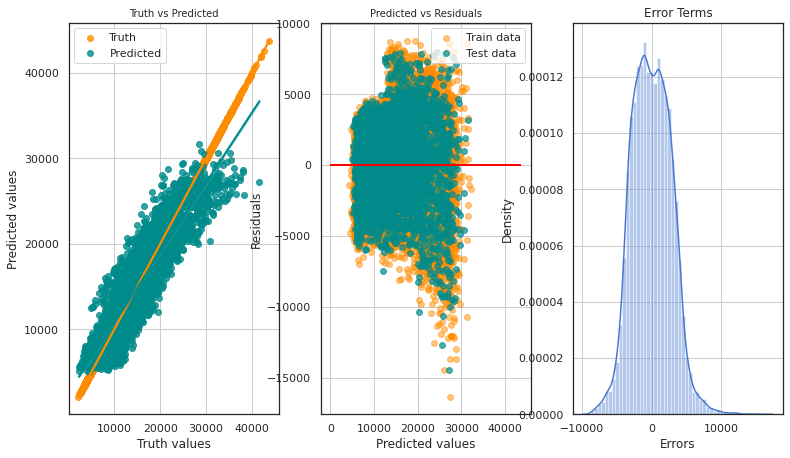

,Truth,Predicted
0,8992.0,10644.7
1,25113.6,26935.8
2,24315.2,25416.5
3,14976.0,11919.9
4,8992.0,10933.3
5,18840.0,23202.7
6,25410.0,26005.2
7,12915.0,14904.4
8,11502.0,10816.8
9,20010.0,20594.2


In [54]:
build_ml_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 96)                4128      
_________________________________________________________________
dense_86 (Dense)             (None, 160)               15520     
_________________________________________________________________
dropout_81 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 352)               56672     
_________________________________________________________________
dropout_82 (Dropout)         (None, 352)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 480)               169440    
_________________________________________________________________
dropout_83 (Dropout)         (None, 480)              

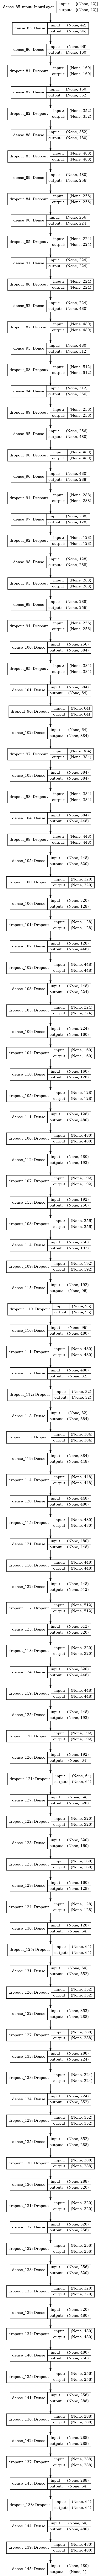

In [55]:
model.summary()
plot_model(model, show_shapes=True)

In [56]:
model.save(f"dl_model_{time_stamp}")
shutil.make_archive(f"dl_model_{time_stamp}", "zip", f"./dl_model_{time_stamp}")
dump(preprocessor, open(f"dl_preprocessor.pkl", "wb"))